In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


from functions.parse_data import synth_dataloader
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import random

In [118]:
#Load data
df=synth_dataloader('SMHIdata3_newsurf',drop_cols=False)
#Dumb down surfaces
df=hf.dumb_down_surface(df)

print(df.head())

#Load X_test and y_test
loadpath='pytorch_models/Ultimate_model_0125/data'
X_test = pd.read_csv(loadpath+'/X_test.csv',index_col=0)
y_test = pd.read_csv(loadpath+'/y_test.csv',index_col=0)


   Cloud_B01  Cloud_B02  Cloud_B03  Cloud_B04  Cloud_B05  Cloud_B06  \
0    0.92072    0.90032    0.81937    0.88448    0.89139    0.91441   
1    0.52169    0.50882    0.48280    0.50241    0.50951    0.53268   
2    0.29940    0.29507    0.30924    0.39888    0.47970    0.70832   
3    0.51401    0.49327    0.45420    0.47264    0.47603    0.54040   
4    0.41524    0.42440    0.46368    0.55680    0.66378    0.99693   

   Cloud_B07  Cloud_B08  Cloud_B08A  Cloud_B09  ...  Sat_Zenith_Angle  \
0    0.92868    0.89153     0.94145    0.38836  ...             14.16   
1    0.55200    0.53915     0.57368    0.38162  ...             14.46   
2    0.80920    0.78422     0.88195    0.24766  ...              4.06   
3    0.57843    0.53577     0.60191    0.17078  ...             11.69   
4    1.10311    1.06547     1.11276    0.51378  ...              2.06   

   Sun_Zenith_Angle  Azimuth_Diff_Angle     COT  Cloud_Type  Profile_ID  \
0             68.38               17.39   0.383           3

In [119]:
#Load models
base_path = 'pytorch_models/Ultimate_model_0125/'
model_paths = ['model0/model_file','model1/model_file','model2/model_file','model3/model_file','model4/model_file',
               'model5/model_file','model6/model_file','model7/model_file','model8/model_file','model9/model_file']
models = [torch.load(base_path+model_paths[i]) for i in range(len(model_paths))]

#Manually set quantiles
quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()

#Initialize metric df
model_metrics=pd.DataFrame(columns=['Ensemble_mean','Ensemble_index','NMSE','NMSE w/o B10','Mean_Quantile_Loss','Quantile Rate'])
#Make preds
preds_total=[]
#Make predictions and evaluate
for i,model in enumerate(models):
    preds = model.predict(X_test.to_numpy())
   #Find errors
    mse=np.linalg.norm(y_test.to_numpy()-preds[:,:,est],axis=(0))**2
    norm=np.linalg.norm(y_test.to_numpy(),axis=(0))**2
    nmse=np.mean(mse/norm)
    nmse_no10=np.mean(mse[[0,1,2,3,4,5,6,7,8,10,11]]/norm[[0,1,2,3,4,5,6,7,8,10,11]])
    mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds,quantiles)
    quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)
    #Add to dataframe
    tmp_metrics=pd.DataFrame(data=[[False,i,nmse,nmse_no10,mean_quantile,quant_rate]],columns=['Ensemble_mean','Ensemble_index','NMSE','NMSE w/o B10','Mean_Quantile_Loss','Quantile Rate'])
    model_metrics=pd.concat([model_metrics,tmp_metrics])
    #Keep track of ensemble prediction
    if i==0:
        preds_total=preds
    else:
        preds_total=preds_total+preds

#Now find ensemble predictions
preds_total=preds_total/len(model_paths)

mse=np.linalg.norm(y_test.to_numpy()-preds_total[:,:,est],axis=(0))**2
norm=np.linalg.norm(y_test.to_numpy(),axis=(0))**2
nmse=np.mean(mse/norm)
nmse_no10=np.mean(mse[[0,1,2,3,4,5,6,7,8,10,11]]/norm[[0,1,2,3,4,5,6,7,8,10,11]])
mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds_total,quantiles)
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds_total)
tmp_metrics=pd.DataFrame(data=[[True,np.nan,nmse,nmse_no10,mean_quantile,quant_rate]],columns=['Ensemble_mean','Ensemble_index','NMSE','NMSE w/o B10','Mean_Quantile_Loss','Quantile Rate'])
model_metrics=pd.concat([model_metrics,tmp_metrics])

#print metrics
model_metrics


/tmp/ipykernel_191693/2859833239.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_metrics=pd.concat([model_metrics,tmp_metrics])


,Ensemble_mean,Ensemble_index,NMSE,NMSE w/o B10,Mean_Quantile_Loss,Quantile Rate
0,False,0,0.049935,0.035914,0.621161,"[0.10496666666666667, 0.5098791666666667, 0.86..."
0,False,1,0.049831,0.036894,0.628230,"[0.12269583333333334, 0.4984708333333333, 0.84..."
0,False,2,0.047051,0.036143,0.624996,"[0.10447083333333333, 0.4951333333333333, 0.86..."
0,False,3,0.048781,0.035301,0.616277,"[0.0941375, 0.4884791666666667, 0.871004166666..."
0,False,4,0.047812,0.036630,0.626604,"[0.103, 0.5011416666666667, 0.8671875]"
0,False,5,0.049475,0.037071,0.630491,"[0.1226, 0.47785, 0.8487875]"
0,False,6,0.046390,0.036630,0.623753,"[0.12382916666666667, 0.487575, 0.842108333333..."
0,False,7,0.047773,0.036043,0.620413,"[0.1040375, 0.4988208333333333, 0.876245833333..."
0,False,8,0.048816,0.036664,0.627757,"[0.12352083333333333, 0.5282375, 0.86895]"
0,False,9,0.047843,0.036021,0.624073,"[0.1126375, 0.489975, 0.8609916666666667]"


In [120]:
print('Means of single network metrics:')
print(np.mean(model_metrics.iloc[0:10,2:5],axis=0))
print('Stds of single network metrics:')
print(np.std(model_metrics.iloc[0:10,2:5],axis=0))
print('Means of single network QR:')
print(np.mean(np.vstack(model_metrics.iloc[0:10,5].to_numpy()),axis=0))
print('Stds of single network QR:')
print(np.std(np.vstack(model_metrics.iloc[0:10,5].to_numpy()),axis=0))
print('Ensemble QR')
model_metrics.iloc[10,5]

Means of single network metrics:
NMSE                  0.048371
NMSE w/o B10          0.036331
Mean_Quantile_Loss    0.624375
dtype: float64
Stds of single network metrics:
NMSE                  0.001130
NMSE w/o B10          0.000510
Mean_Quantile_Loss    0.004014
dtype: float64
Means of single network QR:
[0.11158958 0.49755625 0.86149792]
Stds of single network QR:
[0.01033329 0.01319919 0.0105891 ]
Ensemble QR


array([0.083675  , 0.50084167, 0.90540417])

In [121]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm((y_test.to_numpy())-(X_test.to_numpy()[:,:12]),axis=(0))**2
norm_pred=np.linalg.norm((y_test.to_numpy())-preds_total[:,:,est],axis=(0))**2
norm_gt=np.linalg.norm(y_test.to_numpy(),axis=(0))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(NMSE_pred)))

NMSE before correction, Band 2: 0.8433214629198728
NMSE after correction, Band 2: 0.03359129640349624
 
NMSE before correction, Band 3: 0.521615790405221
NMSE after correction, Band 3: 0.028398712783637092
 
NMSE before correction, Band 4: 0.40925287551461936
NMSE after correction, Band 4: 0.03377676231575336
 
NMSE before correction, Band 5: 0.24255335244215717
NMSE after correction, Band 5: 0.022964064243780467
 
NMSE before correction, Band 6: 0.07469042319115585
NMSE after correction, Band 6: 0.012779213307044974
 
NMSE before correction, Band 7: 0.05552753907035505
NMSE after correction, Band 7: 0.012316941356632761
 
NMSE before correction, Band 8: 0.06011054713010656
NMSE after correction, Band 8: 0.012271688613983964
 
NMSE before correction, Band 8A: 0.04757101461676932
NMSE after correction, Band 8A: 0.01254706228970101
 
NMSE before correction, Band 9: 0.797555098600952
NMSE after correction, Band 9: 0.06357544702151925
 
NMSE before correction, Band 10: 4.6104656960246455
N

In [122]:
#Find test df
df_test=df.iloc[y_test.index]
#Find COTs of all test points
COTs=np.array(df_test['COT'])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = preds_total[(COTs==0),:,:]
clear_inp = X_test.to_numpy()[(COTs==0),:12]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<=1.25),:]
thin_pred = preds_total[(COTs>0) & (COTs<=1.25),:,:]
thin_inp = X_test.to_numpy()[(COTs>0) &  (COTs<=1.25),:12]
thick_true = y_test.to_numpy()[(COTs>1.25),:]
thick_pred = preds_total[(COTs>1.25),:,:]
thick_inp = X_test.to_numpy()[(COTs>1.25),:12]

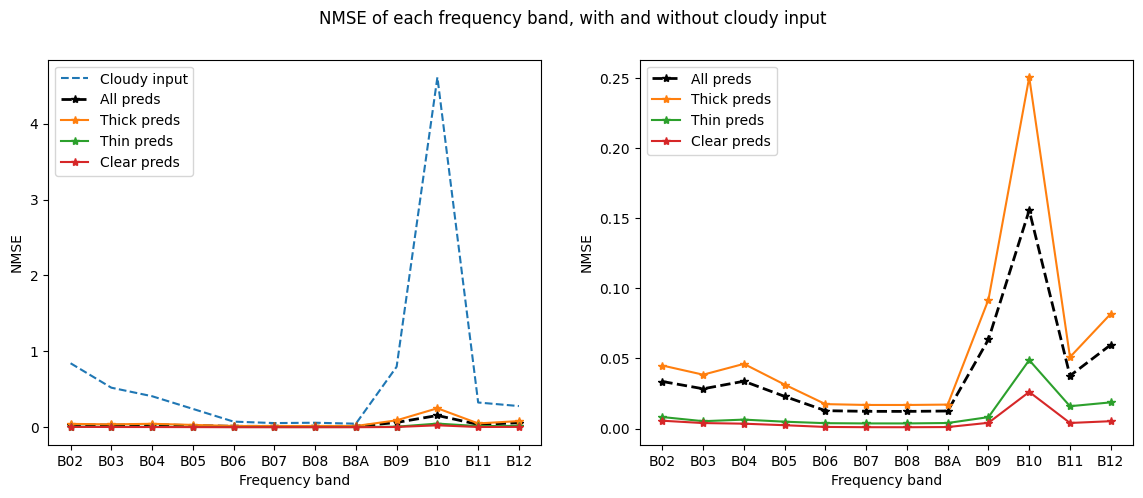

In [123]:
#Find and print NMSE of each band
norm_og=np.linalg.norm((y_test.to_numpy())-(X_test.to_numpy()[:,:12]),axis=(0))**2
norm_pred=np.linalg.norm((y_test.to_numpy())-preds_total[:,:,est],axis=(0))**2
norm_gt=np.linalg.norm(y_test.to_numpy(),axis=(0))**2
NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

norm_pred_clear=np.linalg.norm((clear_true)-clear_pred[:,:,est],axis=(0))**2
norm_gt_clear=np.linalg.norm(clear_true,axis=(0))**2
NMSE_pred_clear=norm_pred_clear/norm_gt_clear

norm_pred_thin=np.linalg.norm((thin_true)-thin_pred[:,:,est],axis=(0))**2
norm_gt_thin=np.linalg.norm(thin_true,axis=(0))**2
NMSE_pred_thin=norm_pred_thin/norm_gt_thin

norm_pred_thick=np.linalg.norm((thick_true)-thick_pred[:,:,est],axis=(0))**2
norm_gt_thick=np.linalg.norm(thick_true,axis=(0))**2
NMSE_pred_thick=norm_pred_thick/norm_gt_thick

'''
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-preds_total[:,:,est]),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred[:,:,est]),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred[:,:,est]),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred[:,:,est]),axis=0)
MAE_cloud_tot = np.mean(np.abs(y_test.to_numpy()-X_test.to_numpy()[:,:12]),axis=0)


plt.figure()
plt.scatter(x,MAE_cloud_tot)
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_thick)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_clear)
'''


bands=np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x=np.arange(np.size(bands))

ncols=2
nrows=1
plt.rcParams['figure.figsize'] = [7*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)

axs[0].plot(x,NMSE_og[bands],'--')
axs[0].plot(x,NMSE_pred[bands],'--*',c='black',linewidth=2)
axs[0].plot(x,NMSE_pred_thick[bands],'-*')
axs[0].plot(x,NMSE_pred_thin[bands],'-*')
axs[0].plot(x,NMSE_pred_clear[bands],'-*')
axs[0].set_xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[0].set_xlabel('Frequency band')
axs[0].set_ylabel('NMSE')
axs[0].legend(['Cloudy input','All preds','Thick preds','Thin preds','Clear preds'],loc='upper left')

axs[1].plot(x,NMSE_pred[bands],'--*',c='black',linewidth=2)
axs[1].plot(x,NMSE_pred_thick[bands],'-*',c='tab:orange')
axs[1].plot(x,NMSE_pred_thin[bands],'-*',c='tab:green')
axs[1].plot(x,NMSE_pred_clear[bands],'-*',c='tab:red')
axs[1].set_xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[1].set_xlabel('Frequency band')
axs[1].set_ylabel('NMSE')
axs[1].legend(['All preds','Thick preds','Thin preds','Clear preds'],loc='upper left')

fig.suptitle('NMSE of each frequency band, with and without cloudy input')
plt.show()

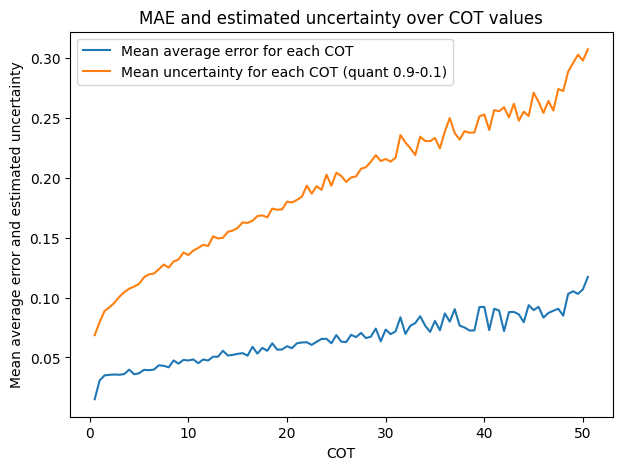

In [124]:
#find sorted numpy indices and sort COT array
COTidx=np.argsort(COTs)
COT_sorted = COTs[COTidx]

#sort numpy test and preds by COT
y_test_np_sort=y_test.to_numpy()[COTidx,:]
y_pred_sort=preds_total[COTidx,:,:]

#Find errors and uncs for chosen bands
all_bands=True
if all_bands:
    errors = np.mean(np.abs(y_test_np_sort[:,:]-y_pred_sort[:,:,est]),axis=1)
    uncs = np.mean(y_pred_sort[:,:,-1]-y_pred_sort[:,:,0],axis=1)
else:
    band = 9
    errors = np.abs(y_test_np_sort[:,band]-y_pred_sort[:,band,est])
    uncs = y_pred_sort[:,band,-1]-y_pred_sort[:,band,0]

#sort errors and uncs into bins based on COT
COTedges=np.linspace(0,50.5,102)
err_bins = np.zeros(len(COTedges)-1)
unc_bins = np.zeros(len(COTedges)-1)
bin_freq = np.zeros(len(COTedges)-1)

for i in range(len(COT_sorted)):
    for j in range(len(COTedges)-1):   
        if COT_sorted[i] >= COTedges[j] and COT_sorted[i] < COTedges[j+1]:
            err_bins[j] = err_bins[j] + errors[i]
            unc_bins[j] = unc_bins[j] + uncs[i]
            bin_freq[j] = bin_freq[j] + 1
            break

#Find mean errs and uncs in each bin
err_mean_bins = err_bins/bin_freq
unc_mean_bins = unc_bins/bin_freq

x_COT=COTedges[:-1]+0.5
plt.rcParams['figure.figsize'] = [7,5]
plt.figure()
plt.plot(x_COT,err_mean_bins)
plt.plot(x_COT,unc_mean_bins)
plt.title('MAE and estimated uncertainty over COT values')
plt.legend(['Mean average error for each COT','Mean uncertainty for each COT (quant 0.9-0.1)'])
plt.xlabel('COT')
plt.ylabel('Mean average error and estimated uncertainty')
plt.show()



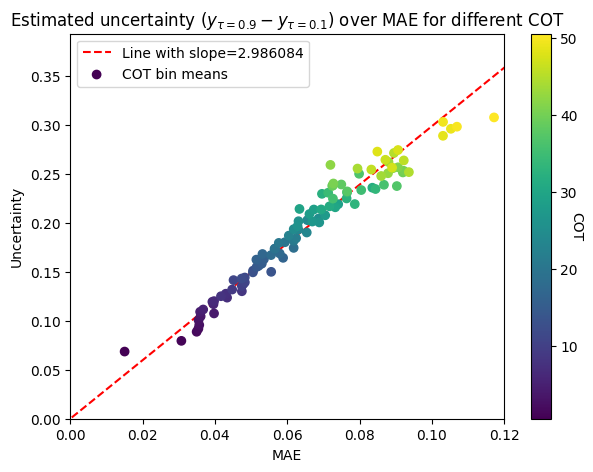

In [125]:
plt.figure()
slope=np.mean(np.divide(unc_mean_bins,err_mean_bins))
line = plt.plot(np.array([-1,1]),slope*np.array([-1,1]),'r--',zorder=0)
sc = plt.scatter(err_mean_bins,unc_mean_bins,c=x_COT,zorder=10)
plt.title(r'Estimated uncertainty ($y_{\tau =0.9}-y_{\tau =0.1}$) over MAE for different COT')
plt.xlabel('MAE')
plt.ylabel('Uncertainty')
plt.legend(['Line with slope=%f' %slope,'COT bin means'])
cb = plt.colorbar(sc)
cb.set_label('COT', rotation=270)
plt.ylim([0,0.393])
plt.xlim([0,0.12])
plt.show()

In [126]:
print(df.Cloud_Type.unique())
#Find all test surfaces
ctypes=np.array(df_test['Cloud_Type'])
#Divide into bins depending on COT
true_0 = y_test.to_numpy()[(ctypes==0),:]
pred_0 = preds_total[(ctypes==0),:,:]
true_1 = y_test.to_numpy()[(ctypes==1),:]
pred_1 = preds_total[(ctypes==1),:,:]
true_2 = y_test.to_numpy()[(ctypes==2),:]
pred_2 = preds_total[(ctypes==2),:,:]
true_3 = y_test.to_numpy()[(ctypes==3),:]
pred_3 = preds_total[(ctypes==3),:,:]
true_4 = y_test.to_numpy()[(ctypes==4),:]
pred_4 = preds_total[(ctypes==4),:,:]
true_5 = y_test.to_numpy()[(ctypes==5),:]
pred_5 = preds_total[(ctypes==5),:,:]
true_6 = y_test.to_numpy()[(ctypes==6),:]
pred_6 = preds_total[(ctypes==6),:,:]
true_mix = y_test.to_numpy()[(ctypes>6),:]
pred_mix = preds_total[(ctypes>6),:,:]

[ 3  2  1  5  4  0  6 10  8  7 11  9]


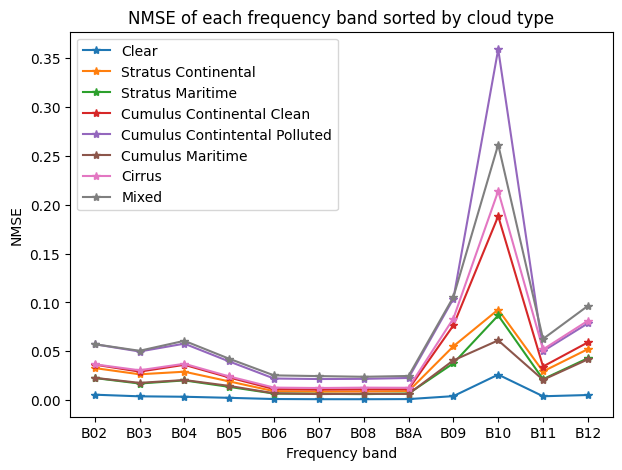

In [127]:
#Find and print MAE of each surface type
norm_pred_0=np.linalg.norm((true_0)-pred_0[:,:,est],axis=(0))**2
norm_gt_0=np.linalg.norm(true_0,axis=(0))**2
NMSE_pred_0=norm_pred_0/norm_gt_0

norm_pred_1=np.linalg.norm((true_1)-pred_1[:,:,est],axis=(0))**2
norm_gt_1=np.linalg.norm(true_1,axis=(0))**2
NMSE_pred_1=norm_pred_1/norm_gt_1

norm_pred_2=np.linalg.norm((true_2)-pred_2[:,:,est],axis=(0))**2
norm_gt_2=np.linalg.norm(true_2,axis=(0))**2
NMSE_pred_2=norm_pred_2/norm_gt_2

norm_pred_3=np.linalg.norm((true_3)-pred_3[:,:,est],axis=(0))**2
norm_gt_3=np.linalg.norm(true_3,axis=(0))**2
NMSE_pred_3=norm_pred_3/norm_gt_3

norm_pred_4=np.linalg.norm((true_4)-pred_4[:,:,est],axis=(0))**2
norm_gt_4=np.linalg.norm(true_4,axis=(0))**2
NMSE_pred_4=norm_pred_4/norm_gt_4

norm_pred_5=np.linalg.norm((true_5)-pred_5[:,:,est],axis=(0))**2
norm_gt_5=np.linalg.norm(true_5,axis=(0))**2
NMSE_pred_5=norm_pred_5/norm_gt_5

norm_pred_6=np.linalg.norm((true_6)-pred_6[:,:,est],axis=(0))**2
norm_gt_6=np.linalg.norm(true_6,axis=(0))**2
NMSE_pred_6=norm_pred_6/norm_gt_6

norm_pred_mix=np.linalg.norm((true_mix)-pred_mix[:,:,est],axis=(0))**2
norm_gt_mix=np.linalg.norm(true_mix,axis=(0))**2
NMSE_pred_mix=norm_pred_mix/norm_gt_mix

'''
MAE_0 = np.mean(np.abs(true_0-pred_0[:,:,est]),axis=0)
MAE_1 = np.mean(np.abs(true_1-pred_1[:,:,est]),axis=0)
MAE_2 = np.mean(np.abs(true_2-pred_2[:,:,est]),axis=0)
MAE_3 = np.mean(np.abs(true_3-pred_3[:,:,est]),axis=0)
MAE_4 = np.mean(np.abs(true_4-pred_4[:,:,est]),axis=0)
MAE_5 = np.mean(np.abs(true_5-pred_5[:,:,est]),axis=0)
MAE_6 = np.mean(np.abs(true_6-pred_6[:,:,est]),axis=0)
MAE_mix= np.mean(np.abs(true_mix-pred_mix[:,:,est]),axis=0)

x=np.arange(np.size(MAE_0))
plt.figure()
plt.scatter(x,MAE_0)
plt.scatter(x,MAE_1)
plt.scatter(x,MAE_2)
plt.scatter(x,MAE_3)
plt.scatter(x,MAE_4)
plt.scatter(x,MAE_5)
plt.scatter(x,MAE_6)
plt.scatter(x,MAE_mix)
'''
bands=np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x=np.arange(np.size(bands))
plt.figure()
plt.plot(x,NMSE_pred_0,'-*')
plt.plot(x,NMSE_pred_1,'-*')
plt.plot(x,NMSE_pred_2,'-*')
plt.plot(x,NMSE_pred_3,'-*')
plt.plot(x,NMSE_pred_4,'-*')
plt.plot(x,NMSE_pred_5,'-*')
plt.plot(x,NMSE_pred_6,'-*')
plt.plot(x,NMSE_pred_mix,'-*')

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('NMSE of each frequency band sorted by cloud type')
plt.xlabel('Frequency band')
plt.ylabel('NMSE')
plt.legend(['Clear','Stratus Continental','Stratus Maritime','Cumulus Continental Clean','Cumulus Contintental Polluted','Cumulus Maritime','Cirrus','Mixed'],loc='upper left')
plt.show()

In [128]:
#Divide into bins depending on ctype
true_0 = y_test.to_numpy()[(ctypes==0) & (COTs < 1.25) ,:]
pred_0 = preds_total[(ctypes==0) & (COTs < 1.25),:,:]
true_1 = y_test.to_numpy()[(ctypes==1) & (COTs < 1.25),:]
pred_1 = preds_total[(ctypes==1) & (COTs < 1.25),:,:]
true_2 = y_test.to_numpy()[(ctypes==2) & (COTs < 1.25),:]
pred_2 = preds_total[(ctypes==2) & (COTs < 1.25),:,:]
true_3 = y_test.to_numpy()[(ctypes==3) & (COTs < 1.25),:]
pred_3 = preds_total[(ctypes==3) & (COTs < 1.25),:,:]
true_4 = y_test.to_numpy()[(ctypes==4) & (COTs < 1.25),:]
pred_4 = preds_total[(ctypes==4) & (COTs < 1.25),:,:]
true_5 = y_test.to_numpy()[(ctypes==5) & (COTs < 1.25),:]
pred_5 = preds_total[(ctypes==5) & (COTs < 1.25),:,:]
true_6 = y_test.to_numpy()[(ctypes==6) & (COTs < 1.25),:]
pred_6 = preds_total[(ctypes==6) & (COTs < 1.25),:,:]
true_mix = y_test.to_numpy()[(ctypes==7) & (COTs < 1.25),:]
pred_mix = preds_total[(ctypes==7) & (COTs < 1.25),:,:]

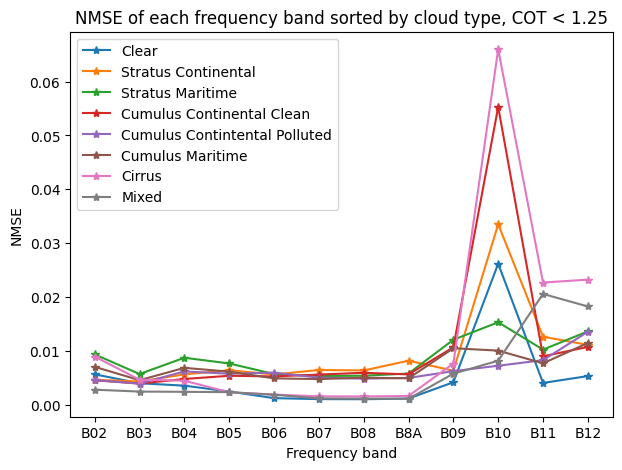

In [129]:
#Find and print MAE of each surface type
norm_pred_0=np.linalg.norm((true_0)-pred_0[:,:,est],axis=(0))**2
norm_gt_0=np.linalg.norm(true_0,axis=(0))**2
NMSE_pred_0=norm_pred_0/norm_gt_0

norm_pred_1=np.linalg.norm((true_1)-pred_1[:,:,est],axis=(0))**2
norm_gt_1=np.linalg.norm(true_1,axis=(0))**2
NMSE_pred_1=norm_pred_1/norm_gt_1

norm_pred_2=np.linalg.norm((true_2)-pred_2[:,:,est],axis=(0))**2
norm_gt_2=np.linalg.norm(true_2,axis=(0))**2
NMSE_pred_2=norm_pred_2/norm_gt_2

norm_pred_3=np.linalg.norm((true_3)-pred_3[:,:,est],axis=(0))**2
norm_gt_3=np.linalg.norm(true_3,axis=(0))**2
NMSE_pred_3=norm_pred_3/norm_gt_3

norm_pred_4=np.linalg.norm((true_4)-pred_4[:,:,est],axis=(0))**2
norm_gt_4=np.linalg.norm(true_4,axis=(0))**2
NMSE_pred_4=norm_pred_4/norm_gt_4

norm_pred_5=np.linalg.norm((true_5)-pred_5[:,:,est],axis=(0))**2
norm_gt_5=np.linalg.norm(true_5,axis=(0))**2
NMSE_pred_5=norm_pred_5/norm_gt_5

norm_pred_6=np.linalg.norm((true_6)-pred_6[:,:,est],axis=(0))**2
norm_gt_6=np.linalg.norm(true_6,axis=(0))**2
NMSE_pred_6=norm_pred_6/norm_gt_6

norm_pred_mix=np.linalg.norm((true_mix)-pred_mix[:,:,est],axis=(0))**2
norm_gt_mix=np.linalg.norm(true_mix,axis=(0))**2
NMSE_pred_mix=norm_pred_mix/norm_gt_mix

'''
MAE_0 = np.mean(np.abs(true_0-pred_0[:,:,est]),axis=0)
MAE_1 = np.mean(np.abs(true_1-pred_1[:,:,est]),axis=0)
MAE_2 = np.mean(np.abs(true_2-pred_2[:,:,est]),axis=0)
MAE_3 = np.mean(np.abs(true_3-pred_3[:,:,est]),axis=0)
MAE_4 = np.mean(np.abs(true_4-pred_4[:,:,est]),axis=0)
MAE_5 = np.mean(np.abs(true_5-pred_5[:,:,est]),axis=0)
MAE_6 = np.mean(np.abs(true_6-pred_6[:,:,est]),axis=0)
MAE_mix= np.mean(np.abs(true_mix-pred_mix[:,:,est]),axis=0)

x=np.arange(np.size(MAE_0))
plt.figure()
plt.scatter(x,MAE_0)
plt.scatter(x,MAE_1)
plt.scatter(x,MAE_2)
plt.scatter(x,MAE_3)
plt.scatter(x,MAE_4)
plt.scatter(x,MAE_5)
plt.scatter(x,MAE_6)
plt.scatter(x,MAE_mix)
'''
bands=np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x=np.arange(np.size(bands))
plt.figure()
plt.plot(x,NMSE_pred_0,'-*')
plt.plot(x,NMSE_pred_1,'-*')
plt.plot(x,NMSE_pred_2,'-*')
plt.plot(x,NMSE_pred_3,'-*')
plt.plot(x,NMSE_pred_4,'-*')
plt.plot(x,NMSE_pred_5,'-*')
plt.plot(x,NMSE_pred_6,'-*')
plt.plot(x,NMSE_pred_mix,'-*')

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('NMSE of each frequency band sorted by cloud type, COT < 1.25')
plt.xlabel('Frequency band')
plt.ylabel('NMSE')
plt.legend(['Clear','Stratus Continental','Stratus Maritime','Cumulus Continental Clean','Cumulus Contintental Polluted','Cumulus Maritime','Cirrus','Mixed'],loc='upper left')
plt.show()

In [130]:
#Find cases where the predicted uncertainty span does not include the +-20% of true value limit
fail_list=[]
fail_band=[]
fail_COT=[]
for i in range(df_test.to_numpy().shape[0]):
    for j in range(len(y_test.columns)):
        if np.abs(y_test.to_numpy()[i,j]-preds_total[i,j,1])/(preds_total[i,j,2]-preds_total[i,j,0]) > 2:
        #if preds_total[i,j,0] > y_test.to_numpy()[i,j]*1.2 or preds_total[i,j,2] < y_test.to_numpy()[i,j]*0.8:
            fail_list.append(i)
            fail_band.append(j)
            fail_COT.append(df['COT'][df_test.index[i]])

#Remove duplicates
fail_list = np.unique(fail_list)
#Turn into df indices
fail_list = df_test.index[fail_list]

print(len(fail_list))

131


In [131]:
#Create df with only fails
fail_df = df.iloc[fail_list,:]
#Find mean COTs
print('mean COT is: ' +str(np.mean(df['COT'])))
print('mean COT for fails is: ' +str(np.mean(fail_df['COT'])))


mean COT is: 14.793501895
mean COT for fails is: 21.58302290076336


B02 culprit in 12.213740458015268% of failed cases
B03 culprit in 8.396946564885496% of failed cases
B04 culprit in 1.5267175572519085% of failed cases
B05 culprit in 3.053435114503817% of failed cases
B06 culprit in 16.03053435114504% of failed cases
B07 culprit in 10.687022900763358% of failed cases
B08 culprit in 14.50381679389313% of failed cases
B8A culprit in 12.213740458015268% of failed cases
B09 culprit in 0.0% of failed cases
B10 culprit in 45.038167938931295% of failed cases
B11 culprit in 14.50381679389313% of failed cases
B12 culprit in 10.687022900763358% of failed cases


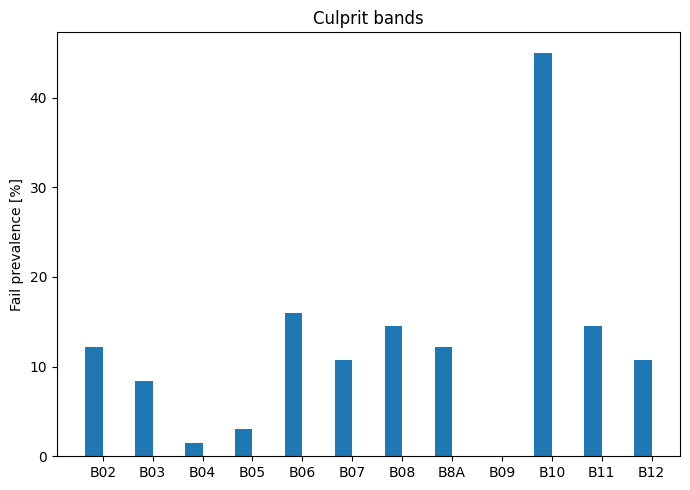

In [132]:
bands=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']
band_fail_count=np.zeros(len(bands))
for b in range(len(bands)):
    band_fail_count[b] = sum(np.array(fail_band)==b)
    print(str(bands[b]) + ' culprit in '+str(band_fail_count[b]*100/len(fail_list))+ '% of failed cases')

x = np.arange(len(bands))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, band_fail_count*100/len(fail_list), width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fail prevalence [%]')
ax.set_title('Culprit bands')
ax.set_xticks(x)
ax.set_xticklabels(bands)
fig.tight_layout()

plt.show()

B02 culprit in 10.638297872340425% of failed cases
B03 culprit in 14.893617021276595% of failed cases
B04 culprit in 4.25531914893617% of failed cases
B05 culprit in 6.382978723404255% of failed cases
B06 culprit in 17.02127659574468% of failed cases
B07 culprit in 6.382978723404255% of failed cases
B08 culprit in 14.893617021276595% of failed cases
B8A culprit in 6.382978723404255% of failed cases
B09 culprit in 0.0% of failed cases
B10 culprit in 2.127659574468085% of failed cases
B11 culprit in 21.27659574468085% of failed cases
B12 culprit in 12.76595744680851% of failed cases


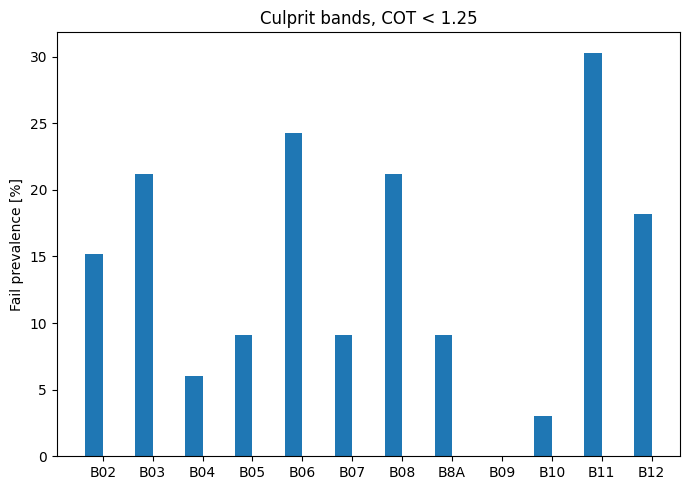

[ 5.  7.  2.  3.  8.  3.  7.  3.  0.  1. 10.  6.]


In [133]:
bands=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']
band_fail_count_thin=np.zeros(len(bands))
for b in range(len(bands)):
    band_fail_count_thin[b] = sum((np.array(fail_band)==b) & (np.array(fail_COT) < 1.25))
    print(str(bands[b]) + ' culprit in '+str(band_fail_count_thin[b]*100/len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])))+ '% of failed cases')

x = np.arange(len(bands))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, band_fail_count_thin*100/len(np.array(fail_df[fail_df['COT']<1.25]['Surface_Desc_Dumb'])), width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fail prevalence [%]')
ax.set_title('Culprit bands, COT < 1.25')
ax.set_xticks(x)
ax.set_xticklabels(bands)
fig.tight_layout()

plt.show()

print(band_fail_count_thin)

0: total: 25.265%, failed: 12.213740458015268%
1: total: 4.705%, failed: 1.5267175572519085%
2: total: 5.0%, failed: 6.106870229007634%
3: total: 4.865%, failed: 3.053435114503817%
4: total: 4.93%, failed: 6.870229007633588%
5: total: 4.795%, failed: 4.580152671755725%
6: total: 25.035%, failed: 22.900763358778626%
7: total: 25.405%, failed: 42.74809160305343%


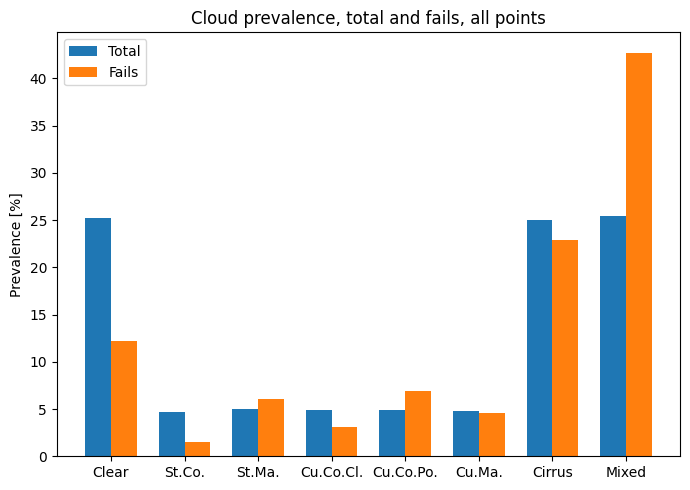

In [134]:
clouds_tot=np.array(df_test['Cloud_Type'])
for i in range(len(clouds_tot)):
    if clouds_tot[i]>6:
        clouds_tot[i]=7
unique_cloud_tot, count_cloud_tot = np.unique(clouds_tot, return_counts=True)

count_cloud_fail = np.zeros(len(unique_cloud_tot))
for i in range(len(unique_cloud_tot)):
    if unique_cloud_tot[i] == 7:
        count_cloud_fail[i] = sum(np.array(fail_df['Cloud_Type'])>=unique_cloud_tot[i])
    else:
        count_cloud_fail[i] = sum(np.array(fail_df['Cloud_Type'])==unique_cloud_tot[i])
    print(str(unique_cloud_tot[i])+': total: '+str(count_cloud_tot[i]/200)+'%, failed: '+str(count_cloud_fail[i]*100/len(fail_list))+'%')

labels=['Clear','St.Co.','St.Ma.','Cu.Co.Cl.','Cu.Co.Po.','Cu.Ma.','Cirrus','Mixed']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count_cloud_tot/200, width, label='Total')
rects2 = ax.bar(x + width/2, count_cloud_fail*100/len(fail_list), width, label='Fails')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence [%]')
ax.set_title('Cloud prevalence, total and fails, all points')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

Clear: total: 85.44132566790667%, failed: 48.484848484848484%
St.Co.: total: 1.2343591477849172%, failed: 0.0%
St.Ma.: total: 2.0459925600270545%, failed: 9.090909090909092%
Cu.Co.Cl.: total: 1.1159959418329388%, failed: 6.0606060606060606%
Cu.Co.Po.: total: 0.8623605005072709%, failed: 6.0606060606060606%
Cu.Ma.: total: 2.3503550896178558%, failed: 3.0303030303030303%
Cirrus: total: 5.1572539736219145%, failed: 21.21212121212121%
Mixed: total: 1.7923571187013865%, failed: 6.0606060606060606%


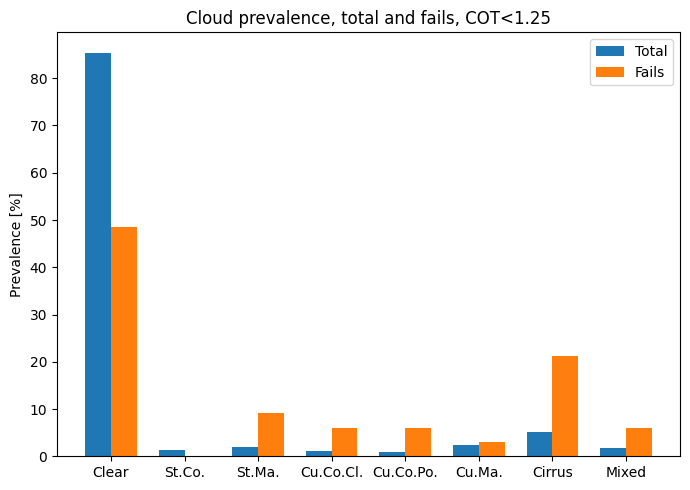

In [135]:
clouds_test_thin = np.array(df_test[df_test['COT']<1.25]['Cloud_Type'])
for i in range(len(clouds_test_thin)):
    if clouds_test_thin[i]>6:
        clouds_test_thin[i]=7
unique_cloud_thin, count_cloud_thin = np.unique(clouds_test_thin, return_counts=True)

count_cloud_fail_thin = np.zeros(len(unique_cloud_thin))
for i in range(len(unique_cloud_thin)):
    if unique_cloud_thin[i] == 7:
        count_cloud_fail_thin[i] = sum(np.array((fail_df['Cloud_Type'])>=unique_cloud_thin[i]) & (np.array(fail_df['COT'])<1.25))
    else:
        count_cloud_fail_thin[i] = sum(np.array((fail_df['Cloud_Type'])==unique_cloud_thin[i]) & (np.array(fail_df['COT'])<1.25))
    print(labels[i]+': total: '+str(count_cloud_thin[i]*100/sum(count_cloud_thin))+'%, failed: '+str(count_cloud_fail_thin[i]*100/len(np.array(fail_df[fail_df['COT']<1.25]['Surface_Desc_Dumb'])))+'%')

labels=['Clear','St.Co.','St.Ma.','Cu.Co.Cl.','Cu.Co.Po.','Cu.Ma.','Cirrus','Mixed']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count_cloud_thin*100/sum(count_cloud_thin), width, label='Total')
rects2 = ax.bar(x + width/2, count_cloud_fail_thin*100/len(np.array(fail_df[fail_df['COT']<1.25]['Surface_Desc_Dumb'])), width, label='Fails')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence [%]')
ax.set_title('Cloud prevalence, total and fails, COT<1.25')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

In [136]:
#Find feature to error coeffs
df_cloud_dum = pd.get_dummies(df_test['Cloud_Type'])
df_surf_dum = pd.get_dummies(df_test['Surface_Desc_Dumb'])
df_coef = pd.concat([df_test,df_cloud_dum,df_surf_dum],axis=1)
df_coef = df_coef.drop(['Profile_ID','Surface_Desc','Cloud_Type','Surface_Desc_Dumb','Cloud_B01','Clear_B01'],axis=1)
unc = np.mean(np.abs(preds_total[:,:,-1]-preds_total[:,:,0]),axis=1)
mae = np.mean(np.abs(y_test.to_numpy()-preds_total[:,:,est]),axis=1)
df_coef = df_coef.assign(UNC=unc)
df_coef = df_coef.assign(MAE=mae)
x_coef = df_coef.values.astype(float)
err_corrs = np.corrcoef(x_coef.T)[:,-1]
for i in range(len(err_corrs)):
    print('Feature: '+str(df_coef.columns[i])+' has corr coef: '+str(err_corrs[i]))

Feature: Cloud_B02 has corr coef: 0.5625754028407527
Feature: Cloud_B03 has corr coef: 0.5052877140773849
Feature: Cloud_B04 has corr coef: 0.4921185475816088
Feature: Cloud_B05 has corr coef: 0.44571141375558243
Feature: Cloud_B06 has corr coef: 0.24309334590305193
Feature: Cloud_B07 has corr coef: 0.16714514978681866
Feature: Cloud_B08 has corr coef: 0.19343654000887112
Feature: Cloud_B08A has corr coef: 0.11640737514148838
Feature: Cloud_B09 has corr coef: 0.40108403938992704
Feature: Cloud_B10 has corr coef: 0.34079970878020277
Feature: Cloud_B11 has corr coef: -0.33381148873833466
Feature: Cloud_B12 has corr coef: -0.27694826784842075
Feature: Clear_B02 has corr coef: 0.10684583477239683
Feature: Clear_B03 has corr coef: 0.0554307605234123
Feature: Clear_B04 has corr coef: 0.051821897245038856
Feature: Clear_B05 has corr coef: 0.002119464166806951
Feature: Clear_B06 has corr coef: -0.07624791657137446
Feature: Clear_B07 has corr coef: -0.0865918216369791
Feature: Clear_B08 has cor

In [137]:
err_corrs = np.corrcoef(x_coef.T)[:,-2]
for i in range(len(err_corrs)):
    print('Feature: '+str(df_coef.columns[i])+' has corr coef: '+str(err_corrs[i]))

Feature: Cloud_B02 has corr coef: 0.8068677060170595
Feature: Cloud_B03 has corr coef: 0.7275445307150131
Feature: Cloud_B04 has corr coef: 0.7067590436933794
Feature: Cloud_B05 has corr coef: 0.6437115867276788
Feature: Cloud_B06 has corr coef: 0.35701136925535815
Feature: Cloud_B07 has corr coef: 0.2459577002441212
Feature: Cloud_B08 has corr coef: 0.2864124263444644
Feature: Cloud_B08A has corr coef: 0.17047204805422547
Feature: Cloud_B09 has corr coef: 0.6047556120212524
Feature: Cloud_B10 has corr coef: 0.513091750684868
Feature: Cloud_B11 has corr coef: -0.5161564648259201
Feature: Cloud_B12 has corr coef: -0.4314286285005343
Feature: Clear_B02 has corr coef: 0.166076089778165
Feature: Clear_B03 has corr coef: 0.10842127340594515
Feature: Clear_B04 has corr coef: 0.10105912947951474
Feature: Clear_B05 has corr coef: 0.04117770118671404
Feature: Clear_B06 has corr coef: -0.03487215036112338
Feature: Clear_B07 has corr coef: -0.038741258387963176
Feature: Clear_B08 has corr coef: -

In [138]:
def quant_rate_bands(y_true,y_pred):
    quantcount = np.zeros([np.shape(y_pred)[1],np.shape(y_pred)[2]])
    for i in range(np.shape(y_pred)[0]):
        for j in range(np.shape(y_pred)[1]):
            for k in range(np.shape(y_pred)[2]):
                if y_true[i,j] < y_pred[i,j,k]:
                    quantcount[j,k] = quantcount[j,k] + 1 

    quantrate = quantcount/np.shape(y_true)[0]

    return quantrate

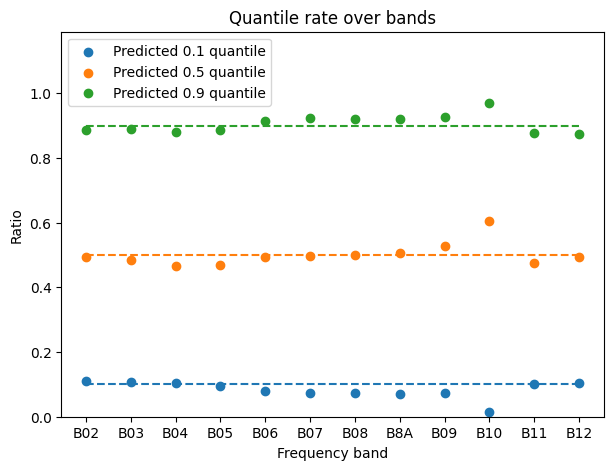

In [139]:
Quant_rates = quant_rate_bands(y_test.to_numpy(),preds_total)

bands=np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x=np.arange(np.size(bands))
plt.figure()

#plt.plot(np.array([0,11]),np.array([0.1,0.1]))
#plt.plot(np.array([0,11]),np.array([0.5,0.5]))
#plt.plot(np.array([0,11]),np.array([0.9,0.9]))

for quant in range(len(quantiles)):
    plt.plot(np.array([bands[0],bands[-1]]),np.array([quantiles[quant],quantiles[quant]]),'--')
    plt.scatter(x,Quant_rates[:,quant],label='Predicted %s quantile'%str(quantiles[quant]))

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Quantile rate over bands')
plt.xlabel('Frequency band')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.ylim([0,1.19])
plt.show()